In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,auc,confusion_matrix,make_scorer
from hyperopt import fmin, tpe, hp, Trials
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

**DATA VALIDATION**

- MUSTERI_ID : Müşterileri ayırt eden unique ID'ler.
- LABEL: Müşterinin aldığı Hayat sigortası ürününün çeşidi.
- FLAG: Verinin ait olduğu ay.
- PP_CINSIYET: Sözleşme sahibinin cinsiyeti.
- 1: Erkek
- 2: Kadın
- PP_YAS : Sözleşme sahibinin ay bazlı olarak yaşı.
- PP_MESLEK : Sözleşme sahibinin mesleği.
- PP_MUSTERI_SEGMENTI : Sözleşme sahibinin müşteri segmenti.
- 101: A segment
- 102: B segment
- 103: C segment
- 104: D segment
- 105: E segment
- 106: F segment
- PP_UYRUK: Sözleşme sahibinin uyruk bilgisi.
- 1:TC Vatandaşı
- 2:Mavi Kart
- 3:Yabancı Uyruklu
- IL:Sözleşme sahiplerinin yaşadığı illere ait plaka kodu.( 0 = Yurtdışı)
- SORU_YATIRIM_KARAKTERI_CVP: Sözleşme sahibinin ankete verdiği cevaplara göre belirlenen yatırım karakteri.
- SORU_YATIRIM_KARAKTERI_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_MEDENI_HAL_CVP: Sözleşme sahibinin ankete verdiği cevaba göre medeni durumu.
- SORU_MEDENI_HAL_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_EGITIM_CVP: Sözleşme sahibinin ankete verdiği cevaplara göre eğitim durumu.
- SORU_EGITIM_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_GELIR_CVP: Sözleşme sahibinin ankete verdiği cevaba göre gelir durumu.
- SORU_GELIR_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- SORU_COCUK_SAYISI_CVP: Sözleşme sahibinin ankete verdiği cevaba göre çocuk sayısı.
- SORU_COCUK_SAYISI_RG: Sözleşme sahibinin ankette verdiği cevabın üstünden geçen süre (ay).
- BES_AYRILMA_TALEP_ADET : Sözleşme sahibinin BES hesabından ayrılmak için açtığı talep sayısı.
- ODEM EME_TALEP_ADET : Sözleşme sahibinin son 1 sene içerisinde kaç kez ödememe talimatı verdiğini gösterir.
- HAYAT_AYRILMA_TALEP_ADET : Sözleşme sahibinin Hayat sigortasından ayrılmak için açtığı talep sayısı.
- BILGI_TALEP_ADET : Sözleşme sahibinin sözleşmesi için kaç kez bilgi talep ettiğini gösterir.
- VADE_TUTAR_0 - VADE_TUTAR_11 : Sözleşme sahibinin sahip olduğu ürünlerin son 12 aya ait toplam vade tutarları
- ODEME_TUTAR_0 - ODEME_TUTAR_11 : Sözleşme sahibinin sahip olduğu ürünler için son 12 ayda yaptığı ödeme tutarları
- SON_AY_KATKI_MIKTARI : Sözleşme sahibinin son bir ay içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_AY_KATKI_ADET : Sözleşme sahibinin son bir ay içinde yaptığı ek katkı ödemelerinin adedi
- SON_CEYREK_KATKI_MIKTARI : Sözleşme sahibinin son üç ay içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_CEYREK_KATKI_ADET : Sözleşme sahibinin son üç ay içinde yaptığı ek katkı ödemelerinin adedi
- SON_SENE_KATKI_MIKTARI : Sözleşme sahibinin son bir sene içinde yaptığı ek katkı ödemelerinin TL cinsinden toplam miktarı
- SON_SENE_KATKI_ADET : Sözleşme sahibinin son bir sene içinde yaptığı ek katkı ödemelerinin adedi
- ANAPARA: Sözleşme sahibinin TL cinsinden toplam yatırdığı para miktarı.
- GETIRI : Sözleşme sahibinin TL cinsinden yatirdiği paradan elde ettiği getiri.
- BU1 - BU24: BES ÜRÜN 1 - 24, Kişinin kolonda belirtilen BES ürününe sahip olup olmama durumu (Ürün özellikleri ayrı bir dokumanda verilmiştir)
- HU1 - HU19: HAYAT ÜRÜN 1 - 19, Kişinin kolonda belirtilen Hayat ürününe sahip olup olmama durumu (Ürün özellikleri ayrı bir dokumanda verilmiştir)
- AKTIF_ILK_POLICE_RG: Sözleşme sahibinin aktif olan poliçeleri arasından en eskisinin üstünden geçen süre (ay).


In [2]:
train = pd.read_csv("data/train.csv")
train["ID"] = range(0,len(train))
train.tail()

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,SORU_GELIR_CVP,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
852714,4a245f1a49af39319faa41668d6ee425fb71c7a75e8b22fab2f39be5ecd76739,UA,MAYIS,1,551,İşçi,105,1,35,NaN,NaN,Married,9.0,Lisans,9.0,NaN,NaN,NaN,NaN,0,0,0,0,430,430,430,430,430,430,0,0,1914,1914,1914,1914,1914,1914,1914,1914,1914,1914,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,10295,1816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,852714
852715,2087a8e5f1f98d143011df1cccaa0331e3427b1a1e642e265370aed1c8d566fa,UA,HAZIRAN,2,466,Ev Hanımı,104,1,33,NaN,NaN,Married,53.0,Lisans,53.0,30000.0,53.0,NaN,NaN,0,0,0,0,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,736,736,736,736,736,736,736,736,736,736,736,736,736,736,NaN,NaN,NaN,NaN,NaN,NaN,30033,34287,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,852715
852716,8d4dccb1bd4763e909476935805d99b84e7f2098b646b7f1f7cd3f41ed5d60fb,UA,MAYIS,1,139,İşçi,106,1,28,NaN,NaN,Single,234.0,Lise,234.0,4000.0,234.0,0.0,234.0,0,0,0,0,317,0,317,0,317,0,317,0,174,0,174,0,174,0,174,0,174,0,174,0,174,0,174,0,NaN,NaN,NaN,NaN,NaN,NaN,17,-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,852716
852717,e33a48c42db1da438d54da64cf59ef4acae4583bd4effcb727648c91269d7a16,UA,MAYIS,2,303,NaN,106,1,20,NaN,NaN,Single,74.0,(Diğer),74.0,3000.0,74.0,NaN,NaN,0,0,0,0,430,0,430,0,430,0,430,0,229,0,229,0,229,0,229,0,229,0,229,0,229,0,229,0,NaN,NaN,NaN,NaN,NaN,NaN,0,195,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,852717
852718,59fd829fc435bf3ed0aa832ca0c89397e5197d8cc135187362d77495cc5d5bdd,UA,MAYIS,2,325,Ev Hanımı,106,1,47,NaN,NaN,Married,46.0,Lise,46.0,3000.0,46.0,NaN,NaN,0,0,0,0,430,0,430,0,430,0,430,0,229,0,229,0,229,0,229,0,229,0,229,0,229,0,229,0,NaN,NaN,NaN,NaN,NaN,NaN,10,-10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,852718


In [3]:
train.shape

(852719, 98)

In [4]:
test = pd.read_csv("data/test.csv")
test_initial_id = 852719
test["LABEL"] = np.nan
test["ID"] = range(test_initial_id,test_initial_id + len(test))
test = test[train.columns]
test.head()

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,SORU_GELIR_CVP,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8,NaN,KASIM,2,467,Öğretmen,103,1,1.0,NaN,NaN,Married,101.0,NaN,NaN,3000,101.0,0.0,101.0,0,0,0,0,602,0,602,0,602,0,602,0,602,0,602,0,602,0,602,0,602,0,602,0,325,0,325,0,NaN,NaN,NaN,NaN,NaN,NaN,6121,16488,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,852719
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0,NaN,KASIM,1,658,Öğretmen,106,1,54.0,NaN,NaN,Married,112.0,Lisans,112.0,2800,112.0,2.0,112.0,0,0,0,0,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,976,526,526,526,526,NaN,NaN,NaN,NaN,NaN,NaN,42088,99179,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,852720
2,47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e,NaN,KASIM,1,634,Serbest Meslek,106,1,48.0,NaN,NaN,Married,219.0,Lise,219.0,2000,219.0,0.0,219.0,0,0,0,0,2497,0,2497,0,2497,0,2497,0,2497,0,2497,0,2497,0,2497,0,2497,0,2497,0,1349,0,1349,0,NaN,NaN,NaN,NaN,NaN,NaN,98,1008,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127,852721
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87,NaN,KASIM,2,638,NaN,106,1,67.0,NaN,NaN,Married,208.0,Lise,208.0,0,208.0,0.0,208.0,0,0,0,0,679,0,679,0,679,0,679,0,679,0,679,0,679,0,679,0,679,0,679,0,363,0,363,0,NaN,NaN,NaN,NaN,NaN,NaN,368,2213,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,178,852722
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7,NaN,KASIM,1,80,Öğrenci,106,1,34.0,NaN,NaN,Single,4.0,(Diğer),4.0,NaN,NaN,NaN,NaN,0,0,0,0,334,334,334,334,334,334,334,334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1184,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,852723


In [5]:
test.shape

(195631, 98)

In [6]:
submission_df = pd.read_csv("data/sample_submission.csv")
submission_df.head()

,MUSTERI_ID,LABEL
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd565cea33fe24f516a8,NaN
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32db98d7d58442898bd0,NaN
2,47498c1c6161aea484b0eed7997846919ca9287684aee4046cc2708b7985fb9e,NaN
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c264984266878976dccd6b87,NaN
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a35872a6756a00c6cb29a7,NaN


In [7]:
submission_df.shape

(195631, 2)

**Submission ve test datada MUSTERİ ID kontrolü**

In [8]:
customer_id_check= submission_df["MUSTERI_ID"] == test["MUSTERI_ID"]
diff_customer_id = len(test) - customer_id_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_customer_id)

Değerleri farklı olan satır sayısı: 0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852719 entries, 0 to 852718
Data columns (total 98 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   MUSTERI_ID                  852719 non-null  object 
 1   LABEL                       852719 non-null  object 
 2   FLAG                        852719 non-null  object 
 3   PP_CINSIYET                 852719 non-null  int64  
 4   PP_YAS                      852719 non-null  int64  
 5   PP_MESLEK                   764099 non-null  object 
 6   PP_MUSTERI_SEGMENTI         852719 non-null  int64  
 7   PP_UYRUK                    852719 non-null  int64  
 8   IL                          852719 non-null  int64  
 9   SORU_YATIRIM_KARAKTERI_CVP  132698 non-null  object 
 10  SORU_YATIRIM_KARAKTERI_RG   132698 non-null  float64
 11  SORU_MEDENI_HAL_CVP         850939 non-null  object 
 12  SORU_MEDENI_HAL_RG          850939 non-null  float64
 13  SORU_EGITIM_CV

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PP_CINSIYET,852719.0,1.494226,0.499967,1.0,1.0,1.0,2.0,2.0
PP_YAS,852719.0,440.773115,205.058165,0.0,316.0,470.0,585.0,1474.0
PP_MUSTERI_SEGMENTI,852719.0,104.740901,1.425773,101.0,104.0,105.0,106.0,106.0
PP_UYRUK,852719.0,1.007269,0.107100,1.0,1.0,1.0,1.0,3.0
IL,852719.0,31.022318,18.434540,0.0,16.0,34.0,39.0,81.0
SORU_YATIRIM_KARAKTERI_RG,132698.0,28.250674,11.966714,0.0,20.0,29.0,38.0,50.0
SORU_MEDENI_HAL_RG,850939.0,87.329307,69.144079,0.0,23.0,78.0,126.0,1482.0
SORU_EGITIM_RG,725624.0,84.778107,71.030740,0.0,21.0,68.0,125.0,1482.0
SORU_GELIR_RG,574817.0,103.253851,63.343308,0.0,55.0,97.0,141.0,1482.0
SORU_COCUK_SAYISI_CVP,436159.0,0.112335,4.568026,0.0,0.0,0.0,0.0,3000.0


MUSTERI_ID

In [11]:
train["MUSTERI_ID"].nunique()

852719

In [12]:
test["MUSTERI_ID"].nunique()

195631

TRAIN ILE TEST BIRLEŞTİRİLİP BERABER İŞLEM YAPILACAK

In [13]:
train_test_concat = pd.concat([train,test],axis=0)

In [14]:
train_test_concat.head(1)

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,SORU_GELIR_CVP,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7,UA,HAZIRAN,2,505,Öğretmen,105,1,34.0,NaN,NaN,Single,68.0,(Diğer),68.0,NaN,NaN,NaN,NaN,0,0,0,0,405,405,405,405,405,405,405,405,405,405,220,220,220,220,220,220,220,220,220,220,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2654,132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0


In [15]:
train_test_concat.tail(1)

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,SORU_GELIR_CVP,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
195630,08c299b06dbf1f9a5e3695f7234c752a53b87654bf336b40f8f2b97ff11ac98d,NaN,ARALIK,2,3,NaN,106,1,35.0,Yetkin,3.0,Single,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,382,382,382,382,382,382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,365.0,1.0,365.0,1.0,1427,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1048349


In [16]:
train_test_concat.shape

(1048350, 98)

EKSİK VERİLER

In [17]:
train_test_concat.isnull().sum()

MUSTERI_ID                          0
LABEL                          195631
FLAG                                0
PP_CINSIYET                         0
PP_YAS                              0
PP_MESLEK                      115059
PP_MUSTERI_SEGMENTI                 0
PP_UYRUK                            0
IL                                  1
SORU_YATIRIM_KARAKTERI_CVP     888265
SORU_YATIRIM_KARAKTERI_RG      888265
SORU_MEDENI_HAL_CVP              2096
SORU_MEDENI_HAL_RG               2096
SORU_EGITIM_CVP                154179
SORU_EGITIM_RG                 154179
SORU_GELIR_CVP                 357601
SORU_GELIR_RG                  357601
SORU_COCUK_SAYISI_CVP          530095
SORU_COCUK_SAYISI_RG           530095
BES_AYRILMA_TALEP_ADET              0
ODEMEME_TALEP_ADET                  0
HAYAT_AYRILMA_TALEP_ADET            0
BILGI_TALEP_ADET                    0
VADE_TUTAR_0                        0
ODEME_TUTAR_0                       0
VADE_TUTAR_1                        0
ODEME_TUTAR_

<Axes: >

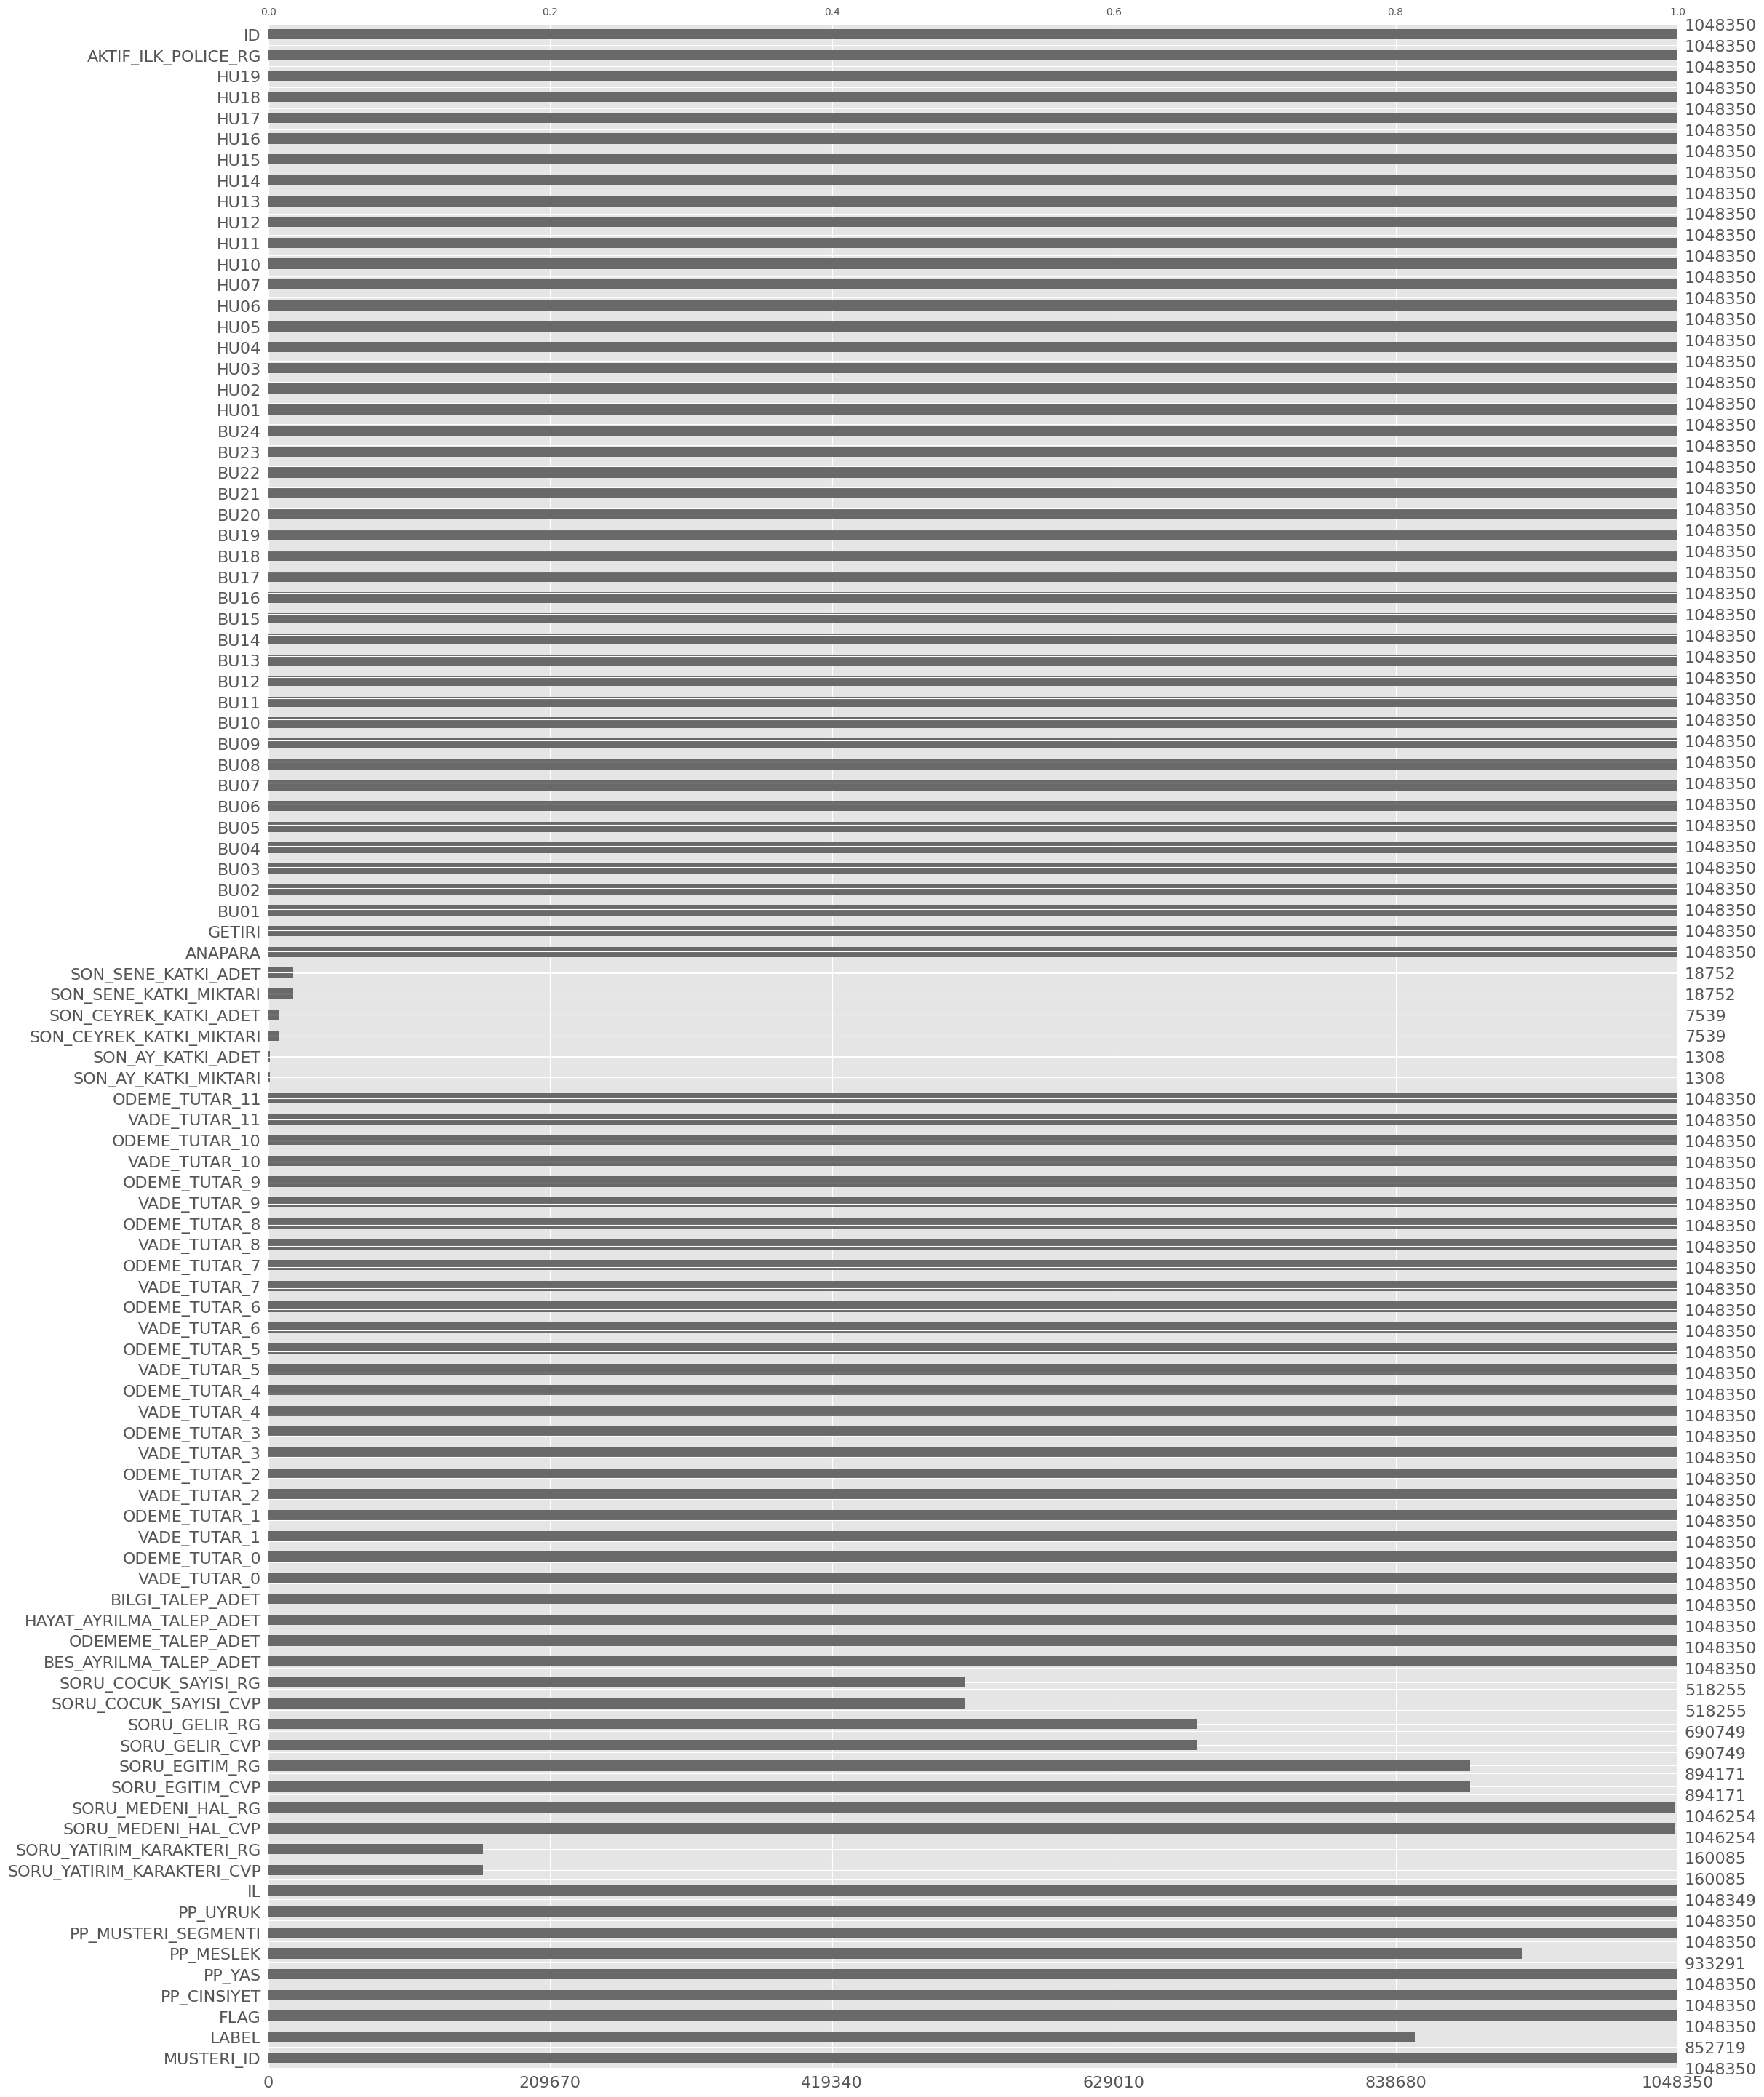

In [18]:
msno.bar(train_test_concat)

- MESLEK kısmında nan gelen verilerin neredeyse tamamında hesapta para bulunduğundan burdaki nan değerler bilinmiyor kategorisine atandı.

In [19]:
train_test_concat.loc[(train_test_concat["PP_MESLEK"].isnull()) & (train_test_concat["ANAPARA"]==0), ["MUSTERI_ID","ANAPARA","PP_MESLEK"]].shape

(403, 3)

In [20]:
train_test_concat["PP_MESLEK"].fillna("Bilinmiyor",inplace=True)

- 1 adet boş İL verisi en yüksek mode olan Istanbul olarak atandı

In [21]:
train_test_concat.loc[train_test_concat["IL"].isnull(),["IL","MUSTERI_ID","ANAPARA"]]

,IL,MUSTERI_ID,ANAPARA
147764,NaN,ed6d0a711152bd338496528fd921b676e47e1b7a770f09362cb1303a9e6007ca,25327


In [22]:
train_test_concat.loc[train_test_concat["IL"].isnull(),"IL"] = 34

In [23]:
train_test_concat["IL"] = train_test_concat["IL"].astype(int)

- SORU_YATIRIM_KARAKTERI_CVP daki nan değerler bilinmiyor yapıldı RG dekilerde -99 atandı integera çevrildi

In [24]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].fillna("Bilinmiyor",inplace=True)
train_test_concat["SORU_YATIRIM_KARAKTERI_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_YATIRIM_KARAKTERI_RG"] = train_test_concat["SORU_YATIRIM_KARAKTERI_RG"].astype(int)

In [25]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].value_counts(dropna=False)

SORU_YATIRIM_KARAKTERI_CVP
Bilinmiyor    888265
Temkinli       41920
Cesur          40046
Dengeli        31179
Yetkin         24215
Bilge          22725
Name: count, dtype: int64

- SORU_MEDENI_HAL_CVP nan değerler Unknown kategorisine atandı rg dekilerde -99 yapıldı integera çevrildi

In [26]:
train_test_concat["SORU_MEDENI_HAL_CVP"].fillna("Unknown",inplace=True)
train_test_concat["SORU_MEDENI_HAL_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_MEDENI_HAL_RG"] = train_test_concat["SORU_MEDENI_HAL_RG"].astype(int)

In [27]:
train_test_concat["SORU_MEDENI_HAL_CVP"].value_counts(dropna=False)

SORU_MEDENI_HAL_CVP
Married               576998
Single                429275
Divorced               31516
Widowed                 8439
Unknown                 2096
Other                     16
Marriage Cancelled         8
Marriage Annulled          2
Name: count, dtype: int64

- SORU_EGITIM_CVP nan değerler Bilinmiyor kategorisine atandı rg dekilerde -99 yapıldı integera çevrildi

In [28]:
train_test_concat["SORU_EGITIM_CVP"].fillna("Bilinmiyor",inplace=True)
train_test_concat["SORU_EGITIM_RG"].fillna(-99,inplace=True)
train_test_concat["SORU_EGITIM_RG"] = train_test_concat["SORU_EGITIM_RG"].astype(int)

In [29]:
train_test_concat["SORU_EGITIM_CVP"].value_counts(dropna=False)

SORU_EGITIM_CVP
Lise             294507
Lisans           260836
(Diğer)          171553
Bilinmiyor       154179
İlköğretim       120167
Yüksek Lisans     23033
Önlisans          19539
Doktora            4536
Name: count, dtype: int64

- SORU_COCUK_SAYISI_CVP çok fazla eksik veri var değişken drop edildi

In [30]:
train_test_concat.drop(["SORU_COCUK_SAYISI_CVP","SORU_COCUK_SAYISI_RG"],axis=1,inplace=True)

- SON_AY_KATKI_MIKTARI, SON_AY_KATKI_ADET, SON_CEYREK_KATKI_MIKTARI, SON_CEYREK_KATKI_ADET, SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET değişkenlerindeki eksik veriler katkı olmadı anlamında 0 ile dolduruldu  

In [31]:
son_columns_bool = train_test_concat.columns.str.contains("SON")
son_columns=train_test_concat.loc[:,son_columns_bool].columns
for column in son_columns:
    train_test_concat[column].fillna(0,inplace=True)
train_test_concat[son_columns]=train_test_concat[son_columns].astype(int)


**SORU_GELIR_CVP ve SORU_GELIR_RG Eksik veri işlemleri**
- Değişkende 357601 adet eksik veri vardır.
- Aykırı yazılmış değerler bulunmakdadır
- İnsanlar gelirlerini her zaman doğru şekilde yazmayabilirler. Geliri yüksek gösterme eğiliminde de olabilirler
- Bu nedenlerden dolayı yanıltıcı sonuçlar oluşabileceğinden bu değişkenleri veri setinden kaldırmayı uygun görülmüştür.

In [32]:
train_test_concat.drop(["SORU_GELIR_CVP","SORU_GELIR_RG"],axis=1,inplace=True)

In [33]:
train_test_concat.isnull().sum()

MUSTERI_ID                         0
LABEL                         195631
FLAG                               0
PP_CINSIYET                        0
PP_YAS                             0
PP_MESLEK                          0
PP_MUSTERI_SEGMENTI                0
PP_UYRUK                           0
IL                                 0
SORU_YATIRIM_KARAKTERI_CVP         0
SORU_YATIRIM_KARAKTERI_RG          0
SORU_MEDENI_HAL_CVP                0
SORU_MEDENI_HAL_RG                 0
SORU_EGITIM_CVP                    0
SORU_EGITIM_RG                     0
BES_AYRILMA_TALEP_ADET             0
ODEMEME_TALEP_ADET                 0
HAYAT_AYRILMA_TALEP_ADET           0
BILGI_TALEP_ADET                   0
VADE_TUTAR_0                       0
ODEME_TUTAR_0                      0
VADE_TUTAR_1                       0
ODEME_TUTAR_1                      0
VADE_TUTAR_2                       0
ODEME_TUTAR_2                      0
VADE_TUTAR_3                       0
ODEME_TUTAR_3                      0
V

# KEŞİFSEL VERİ ANALİZİ

In [34]:
def single_variable_multiple_plot(data,type="float64",numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype == type]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category","int32"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

- GETIRI VE ANAPARADA AYKIRI DEĞER TESPİTİ

In [35]:
def outlier_thresholds(dataframe, variable, q1_thr=0.25, q3_thr=0.75):
    """
    Calculate the lower and upper bounds to cap outliers in a variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the variable.
    variable : str
        The name of the variable for which to calculate the outlier thresholds.
    q1_thr : float, optional
        The quantile value for the lower quartile. Default is 0.25.
    q3_thr : float, optional
        The quantile value for the upper quartile. Default is 0.75.

    Returns
    -------
    low_limit : float
        The lower bound threshold for capping outliers.
    up_limit : float
        The upper bound threshold for capping outliers.
    """
    quartile1 = dataframe[variable].quantile(q1_thr)
    quartile3 = dataframe[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [36]:
train_test_concat[["ANAPARA","GETIRI"]].describe().T

,count,mean,std,min,25%,50%,75%,max
ANAPARA,1048350.0,17459.677132,39951.331455,0.0,952.0,4581.0,17141.0,957000.0
GETIRI,1048350.0,33507.937720,114670.483848,-334227.0,484.0,2805.0,21763.0,8622932.0


In [37]:
train_test_concat[train_test_concat["GETIRI"] < -100000].head()

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
760572,e626835b8bf5e34ef7dc321a2757c7ed979b9bf0a8d4b859e20c7499a4a6b90c,UA,HAZIRAN,1,649,Emekli,102,1,26,Bilinmiyor,-99,Married,232,Lise,232,0,0,0,0,5866,5866,5866,5866,5866,5866,5866,5866,5866,5866,3349,3349,1914,1914,1914,1914,1914,1914,1914,1914,1914,1914,1914,1914,0,0,0,0,0,0,529364,-334227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,760572
784046,ad9666f40ade930ba17e889587017f655f32780b32b7cd313c509d38fd66911a,UA,HAZIRAN,2,533,Memur,102,1,16,Yetkin,43,Married,220,Lisans,220,0,0,0,0,382,382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147793,-113536,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,784046


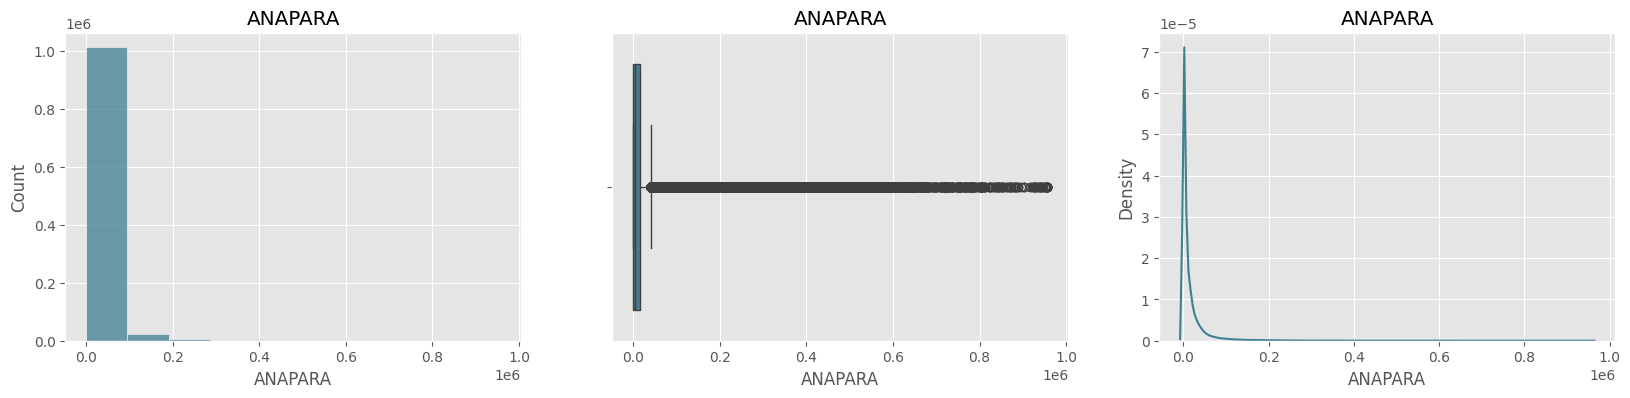

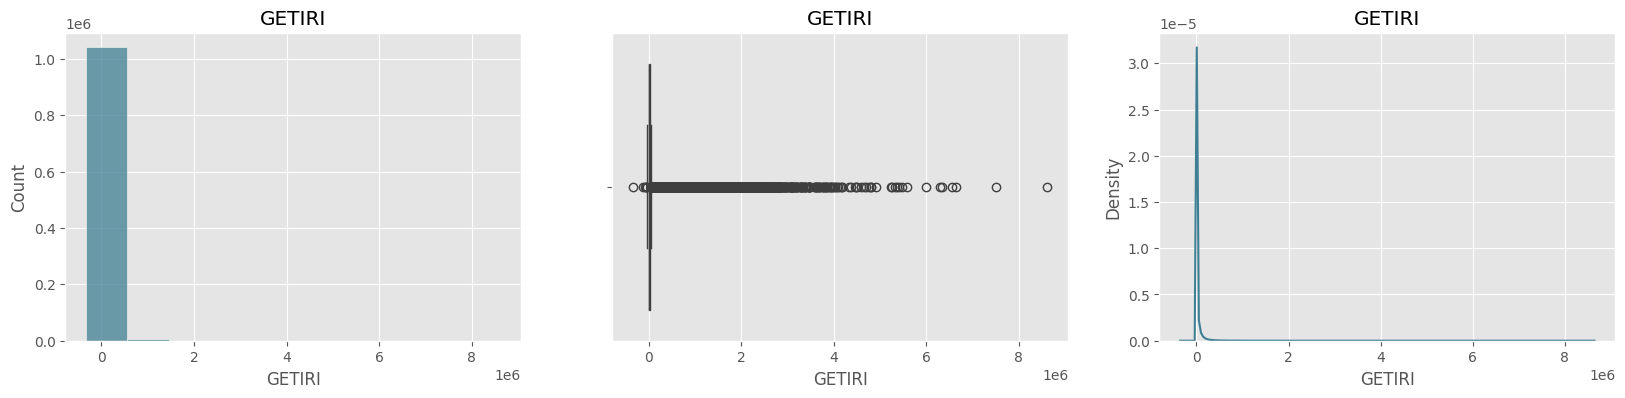

In [38]:
single_variable_multiple_plot(train_test_concat[["ANAPARA","GETIRI"]],type="int64",numeric=True)

GETİRİ

In [39]:
low_limit_getiri, up_limit_getiri = outlier_thresholds(train_test_concat,"GETIRI",q1_thr=0.05,q3_thr=0.95)

In [40]:
low_limit_getiri

-227545.44999999937

In [41]:
up_limit_getiri

379223.74999999895

In [42]:
train_test_concat[(train_test_concat["GETIRI"] < low_limit_getiri) | (train_test_concat["GETIRI"] > up_limit_getiri)].shape

(15219, 94)

In [43]:
# Aykırı değer baskılama
train_test_concat.loc[(train_test_concat["GETIRI"] > up_limit_getiri), "GETIRI"] = up_limit_getiri
train_test_concat.loc[(train_test_concat["GETIRI"] < low_limit_getiri), "GETIRI"] = low_limit_getiri

ANAPARA

In [44]:
low_limit_anapara, up_limit_anapara = outlier_thresholds(train_test_concat,"ANAPARA",q1_thr=0.05,q3_thr=0.95)

In [45]:
low_limit_anapara

-108498.14999999979

In [46]:
up_limit_anapara

180886.24999999965

In [47]:
train_test_concat[train_test_concat["ANAPARA"] > up_limit_anapara].shape

(13175, 94)

In [48]:
# Aykırı değer baskılama
train_test_concat.loc[(train_test_concat["ANAPARA"] > up_limit_anapara), "ANAPARA"] = up_limit_anapara

In [49]:
train_test_concat[["ANAPARA","GETIRI"]].describe().T

,count,mean,std,min,25%,50%,75%,max
ANAPARA,1048350.0,16224.217628,30330.907768,0.00,952.0,4581.0,17141.0,180886.25
GETIRI,1048350.0,28276.236101,65255.150213,-227545.45,484.0,2805.0,21763.0,379223.75


In [50]:
train_test_concat[["ANAPARA","GETIRI"]] = train_test_concat[["ANAPARA","GETIRI"]].astype("int64")

In [51]:
train_test_concat[["ANAPARA","GETIRI"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048350 entries, 0 to 195630
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   ANAPARA  1048350 non-null  int64
 1   GETIRI   1048350 non-null  int64
dtypes: int64(2)
memory usage: 24.0 MB


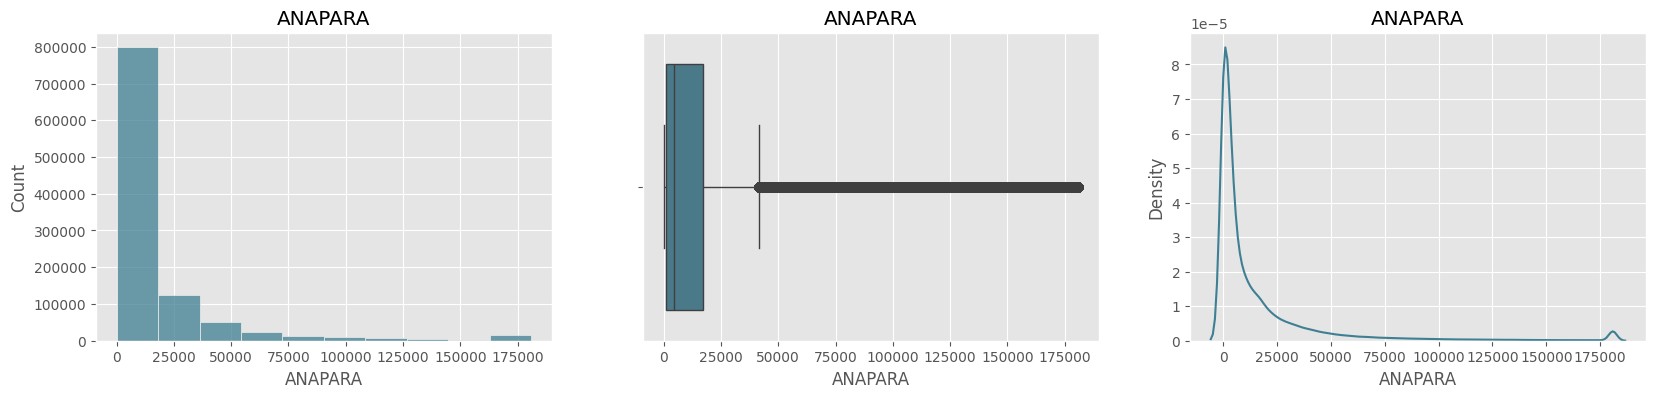

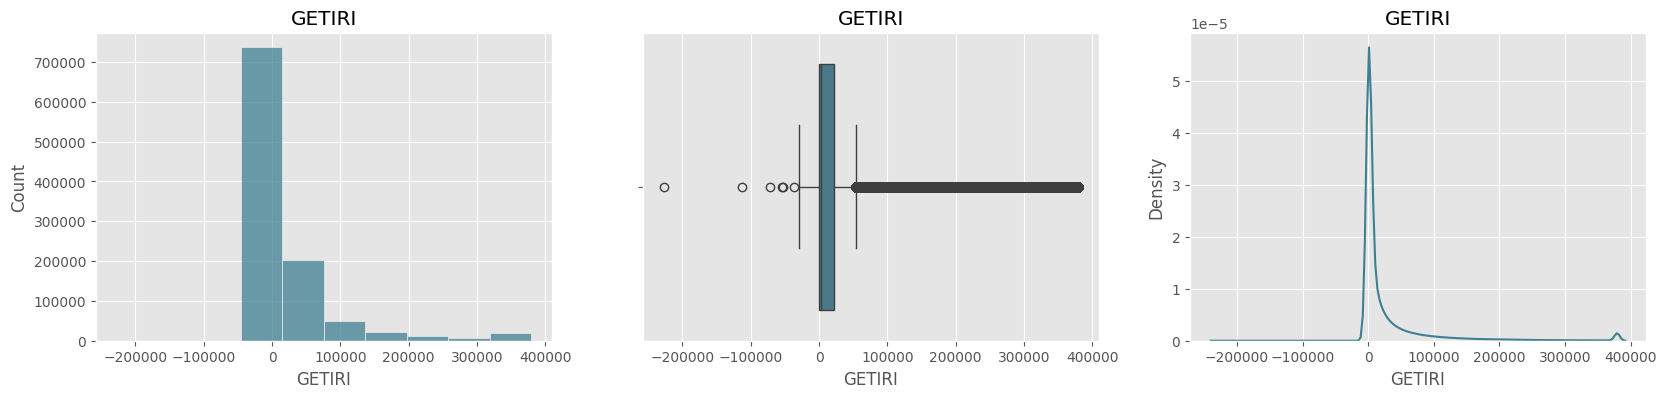

In [52]:
single_variable_multiple_plot(train_test_concat[["ANAPARA","GETIRI"]],type="int64",numeric=True)

- DİĞER ANALİZLER KISMI

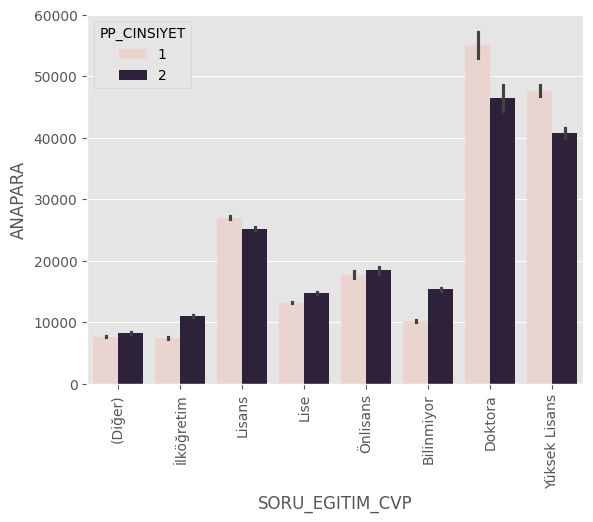

In [53]:
sns.barplot(x="SORU_EGITIM_CVP",y="ANAPARA",hue="PP_CINSIYET",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

# FEATURE ENGINEERING VE ENCODING İŞLEMLERİ

**LABEL değişkeni label encoding yapıldı**

In [54]:
train_test_concat.head(1)

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7,UA,HAZIRAN,2,505,Öğretmen,105,1,34,Bilinmiyor,-99,Single,68,(Diğer),68,0,0,0,0,405,405,405,405,405,405,405,405,405,405,220,220,220,220,220,220,220,220,220,220,0,0,0,0,0,0,0,0,0,0,2654,132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0


In [55]:
train_test_concat["LABEL"].value_counts(dropna=False)

LABEL
UA      832770
NaN     195631
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [56]:
train_test_concat["LABEL"] = train_test_concat["LABEL"].astype("category")
train_test_concat["LABEL"] = train_test_concat["LABEL"].cat.codes

In [57]:
train_test_concat["LABEL"].value_counts(dropna=False)

LABEL
 7    832770
-1    195631
 4     10754
 1      3728
 0      3178
 6       759
 3       676
 2       439
 5       415
Name: count, dtype: int64

**FLAG değişkeni AY olarak değiştirilip sayısal yapıldı**

In [58]:
train_test_concat["FLAG"].value_counts(dropna=False)

FLAG
HAZIRAN    252193
MAYIS      246389
ARALIK     109478
EKIM        93766
EYLUL       89170
TEMMUZ      86460
KASIM       86153
AGUSTOS     84741
Name: count, dtype: int64

In [59]:
train_test_concat["AY"] = train_test_concat["FLAG"].replace({"HAZIRAN":6,"MAYIS":5,"ARALIK":12,"EKIM":10,"EYLUL":9,"TEMMUZ":7,"KASIM":11,"AGUSTOS":8})
train_test_concat.drop("FLAG",axis=1,inplace=True)

In [60]:
train_test_concat["AY"].value_counts(dropna=False)

AY
6     252193
5     246389
12    109478
10     93766
9      89170
7      86460
11     86153
8      84741
Name: count, dtype: int64

**PP_CINSIYET binary kodlandı erkek 1 yine 1, kadın 0 olarak değiştirildi.**

In [61]:
train_test_concat["PP_CINSIYET"].value_counts()

PP_CINSIYET
1    532907
2    515443
Name: count, dtype: int64

In [62]:
train_test_concat["PP_CINSIYET"] = np.where(train_test_concat["PP_CINSIYET"]==1, 1, 0)

In [63]:
train_test_concat["PP_CINSIYET"].value_counts()

PP_CINSIYET
1    532907
0    515443
Name: count, dtype: int64

**PP_YAS Ay bazlıdan normal yaşa çevrildi**

In [64]:
train_test_concat["PP_YAS"] = train_test_concat["PP_YAS"] // 12

**PP_MESLEK kardinalite çok yüksek olduğundan frekans tabanlı ve smooth mean target encoding ile kodlandı**
- Frekans Encoding

In [65]:
train_test_concat["PP_MESLEK"].nunique()

114

In [66]:
train_test_concat["PP_MESLEK"].value_counts()

PP_MESLEK
İşçi                                          170189
Öğrenci                                       128304
Ev Hanımı                                     122378
Bilinmiyor                                    117991
Diğer                                         114750
Öğretmen                                       41559
Esnaf                                          36383
Memur                                          35624
Serbest Meslek                                 31944
Mühendis                                       22807
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)     15447
Danışman                                       10826
Emekli                                         10415
SSK-Sosyal Sigortalar Kurumu Emeklileri         9731
Tacir ve Esnaf                                  9412
Akademisyen                                     8979
Banka                                           8608
Ordu Mensubu                                    8607
Hizmet Çalışanı                     

In [67]:
frequencies = train_test_concat["PP_MESLEK"].value_counts().to_dict()
train_test_concat["PP_MESLEK_FREKANS"] = train_test_concat["PP_MESLEK"].map(frequencies)

- Smooth Mean Target Encoding
- Df yi ilk olarak train test olarak ayırıp smooth mean target encoding uygulandı.

In [68]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

In [69]:
def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

In [70]:
def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

In [71]:
new_train = train_test_concat[train_test_concat["ID"].isin(train["ID"])]
new_test = train_test_concat[train_test_concat["ID"].isin(test["ID"])]
new_test["LABEL"]=np.nan

In [72]:
# Create mean target encoded feature
new_train["PP_MESLEK_ENC"], new_test["PP_MESLEK_ENC"] = mean_target_encoding(train=new_train,test=new_test,target="LABEL",categorical="PP_MESLEK", alpha=10)

In [73]:
print(new_test[['PP_MESLEK', 'PP_MESLEK_ENC']].drop_duplicates())

                                         PP_MESLEK  PP_MESLEK_ENC
0                                         Öğretmen       6.895893
2                                   Serbest Meslek       6.963432
3                                       Bilinmiyor       6.984486
4                                          Öğrenci       6.948999
5                                             İşçi       6.867658
7                                        Ev Hanımı       6.913596
12                                           Diğer       6.985432
15                                          Emekli       6.887034
16                                        Mühendis       6.903872
22                                        İş Adamı       6.837249
28                                        Muhasebe       6.838082
31                                           Banka       6.786086
33                                           Memur       6.891641
41                                 Hizmet Çalışanı       6.569401
44        

- Tekrar train ve test birleştirildi PP_MESLEK drop edildi.

In [74]:
train_test_concat = pd.concat([new_train,new_test],axis=0)
train_test_concat.drop("PP_MESLEK",axis=1, inplace=True)

**PP_MUSTERI_SEGMENTI ordinal kodlandı**
- 101 A segmente öncelik verildi sıralama ona göre devam etti

In [75]:
train_test_concat["PP_MUSTERI_SEGMENTI"].value_counts().sort_index()

PP_MUSTERI_SEGMENTI
101       977
102    131099
103    107090
104    106951
105    251988
106    450245
Name: count, dtype: int64

In [76]:
categories = [106,105,104,103,102,101]
train_test_concat["PP_MUSTERI_SEGMENTI"] = pd.Categorical(train_test_concat["PP_MUSTERI_SEGMENTI"], categories=categories,ordered=True)
train_test_concat["PP_MUSTERI_SEGMENTI"].dtypes

CategoricalDtype(categories=[106, 105, 104, 103, 102, 101], ordered=True, categories_dtype=int64)

In [77]:
train_test_concat["PP_MUSTERI_SEGMENTI"] = train_test_concat["PP_MUSTERI_SEGMENTI"].cat.codes
train_test_concat["PP_MUSTERI_SEGMENTI"].value_counts().sort_index()

PP_MUSTERI_SEGMENTI
0    450245
1    251988
2    106951
3    107090
4    131099
5       977
Name: count, dtype: int64

**PP_UYRUK one hot encoding ile kodlandı**

In [78]:
train_test_concat["PP_UYRUK"].value_counts()

PP_UYRUK
1    1042888
2       3077
3       2385
Name: count, dtype: int64

In [79]:
category_one_hot = pd.get_dummies(train_test_concat["PP_UYRUK"]).astype(int)
train_test_concat.drop("PP_UYRUK", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)
train_test_concat.rename(columns={1:"TC_VAT",2:"MAVIKART",3:"YABANCI"},inplace=True)

**SORU_YATIRIM_KARAKTERI_CVP one hot encoding ile kodlandı**

In [80]:
train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"].value_counts()

SORU_YATIRIM_KARAKTERI_CVP
Bilinmiyor    888265
Temkinli       41920
Cesur          40046
Dengeli        31179
Yetkin         24215
Bilge          22725
Name: count, dtype: int64

In [81]:
category_one_hot = pd.get_dummies(train_test_concat["SORU_YATIRIM_KARAKTERI_CVP"],prefix="YK_").astype(int)
train_test_concat.drop("SORU_YATIRIM_KARAKTERI_CVP", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)

**SORU_MEDENI_HAL_CVP binary encoding ile kodlandı. Veri setitnin büyük çoğunluğunu single ve married oluşturuyor divorced ve diğerleride single kategorisine alındı**

In [82]:
train_test_concat["SORU_MEDENI_HAL_CVP"].value_counts()

SORU_MEDENI_HAL_CVP
Married               576998
Single                429275
Divorced               31516
Widowed                 8439
Unknown                 2096
Other                     16
Marriage Cancelled         8
Marriage Annulled          2
Name: count, dtype: int64

In [83]:
train_test_concat["SORU_MEDENI_HAL_CVP"] = np.where(train_test_concat["SORU_MEDENI_HAL_CVP"] == "Married", 1, 0)

**SORU_EGITIM_CVP one hot encoding ile kodlandı**

In [84]:
train_test_concat["SORU_EGITIM_CVP"].value_counts()

SORU_EGITIM_CVP
Lise             294507
Lisans           260836
(Diğer)          171553
Bilinmiyor       154179
İlköğretim       120167
Yüksek Lisans     23033
Önlisans          19539
Doktora            4536
Name: count, dtype: int64

In [85]:
category_one_hot = pd.get_dummies(train_test_concat["SORU_EGITIM_CVP"],prefix="EGITIM_").astype(int)
train_test_concat.drop("SORU_EGITIM_CVP", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,category_one_hot], axis=1)
train_test_concat.head()

,MUSTERI_ID,LABEL,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,IL,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,ID,AY,PP_MESLEK_FREKANS,PP_MESLEK_ENC,TC_VAT,MAVIKART,YABANCI,YK__Bilge,YK__Bilinmiyor,YK__Cesur,YK__Dengeli,YK__Temkinli,YK__Yetkin,EGITIM__(Diğer),EGITIM__Bilinmiyor,EGITIM__Doktora,EGITIM__Lisans,EGITIM__Lise,EGITIM__Yüksek Lisans,EGITIM__Önlisans,EGITIM__İlköğretim
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7,7.0,0,42,1,34,-99,0,68,68,0,0,0,0,405,405,405,405,405,405,405,405,405,405,220,220,220,220,220,220,220,220,220,220,0,0,0,0,0,0,0,0,0,0,2654,132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,6,41559,6.896819,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd,7.0,0,74,4,20,-99,1,11,11,0,0,0,0,5720,5720,5720,5720,4763,4763,4763,4763,4763,4763,2871,2871,2871,2871,2871,2871,2871,2871,957,957,1914,3828,0,0,0,0,0,0,0,0,62945,75370,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,6,15447,6.949284,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f,6.0,0,48,2,6,26,0,235,235,0,0,0,0,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,631,631,631,631,631,631,631,631,631,631,631,631,631,631,0,0,0,0,0,0,22929,16055,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,66,2,6,5926,6.841099,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5,7.0,0,54,0,34,-99,1,111,111,0,0,0,0,574,0,574,0,574,0,574,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,0,0,0,0,0,0,178,497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,3,5,114750,6.985540,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491,7.0,0,40,3,77,-99,1,91,91,0,0,0,0,459,0,459,0,459,0,459,459,459,459,459,459,459,0,459,0,248,0,248,0,248,0,248,0,0,0,0,0,0,0,1378,1151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,4,9,170189,6.866859,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


**MUSTERI BAZLI TOPLAM ODEME TUTAR TOPLAM VADE TUTAR KOLONLARININ EKLENMESİ**

In [86]:
train_test_concat["TOPLAM_ODEME_TUTAR"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("ODEME_TUTAR")].sum(axis=1)

In [87]:
train_test_concat["TOPLAM_VADE_TUTAR"]=train_test_concat.loc[:,train_test_concat.columns.str.contains("VADE_TUTAR")].sum(axis=1)

In [89]:
train_test_concat[["MUSTERI_ID","TOPLAM_ODEME_TUTAR","TOPLAM_VADE_TUTAR","ANAPARA","GETIRI"]].head()

,MUSTERI_ID,TOPLAM_ODEME_TUTAR,TOPLAM_VADE_TUTAR,ANAPARA,GETIRI
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7,3125,3125,2654,132
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd,41998,40084,62945,75370
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f,10277,10277,22929,16055
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5,0,4744,178,497
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491,1377,4664,1378,1151


# KORELASYON ANALİZİ

In [90]:
len(train_test_concat.columns)

111

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6, 7]
f1_scores = f1_score(y_test, y_pred, average=None, labels=labels)
frekanslar = y.value_counts()
ters_frekanslar = 1 / frekanslar
agirliklar = ters_frekanslar / ters_frekanslar.sum()
f1_pondere = agirliklar[labels] * f1_scores  # labels ile endeksleme, doğru sıralamayı sağlar
agırlıklı_f1_score= f1_pondere.sum()
agırlıklı_f1_score


In [ ]:
from sklearn.metrics import f1_score

# Gerçek sınıflar
gercek_siniflar = [0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 0]

# Tahmin edilen sınıflar
tahmin_siniflar = [0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 0]

# Sınıf ağırlıkları
sinif_agirliklari = {
    0: 0.0385,
    1: 0.0328,
    2: 0.2791,
    3: 0.1812,
    4: 0.0113,
    5: 0.2952,
    6: 0.1614,
    7: 0.0001
}

# F1 skorunu hesaplayın
f1_skoru = f1_score(gercek_siniflar, tahmin_siniflar, average=None)

# Her sınıfın ağırlığıyla F1 skorlarını çarpın
agirlikli_f1_skorlar = [sinif_agirliklari[sinif] * f1_skoru[sinif] for sinif in range(len(sinif_agirliklari))]

# Elde edilen çarpımları toplayarak ağırlıklı F1 skorunu bulun
agirlikli_f1_skoru = sum(agirlikli_f1_skorlar)

print("Ağırlıklı F1 Skoru (Elle Hesaplanmış):", agirlikli_f1_skoru)


Ağırlıklı F1 Skoru (Elle Hesaplanmış): 0.9996
